# Head stabilization

**Author:** Sibo Wang-Chen

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will use mechanosensory information to correct for self motion in closed loop. We will train an internal model that predicts the appropriate neck actuation signals, based on leg joint angles and ground contacts, to minimize head rotations during walking.

## Introduction

In the [previous tutorial](https://neuromechfly.org/tutorials/path_integration.html), we demonstrated how one can integrate ascending mechanosensory information to estimate the fly's position. In this tutorial, we will demonstrate another way in which the fly uses ascending motor signals to complete the sensorimotor control loop.

In flies, head stabilization has been shown to be used to compensate for body pitch and roll ([Kress & Egelhaaf, 2012](https://doi.org/10.1242/jeb.066910)) during locomotion. It is thought that these stabilizing movements may be informed by leg sensory feedback signals ([Gollin & Dürr, 2018](https://doi.org/10.1007/978-3-319-95972-6_20)). To explore head stabilization in our embodied model, we will design a controller in which leg joint angles (i.e., proprioceptive signals, 6 legs × 7 degrees of freedom per leg) and ground contacts (i.e., tactile signals, 6 legs) are given as inputs to a multilayer perceptron (MLP). This model, in turn, predicts the appropriate head roll and pitch required to cancel visual rotations caused by the animal's own body movements during walking. We will use these signals to actuate the neck joint and aim to dampen head rotation. This approach is illustrated as follows:

<p align="center">
<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/head_stabilization/head_stabilization_schematic.png?raw=true" alt="head_stabilization_schematic.png" width="700"/>
</p>

## Collecting training data

We start by running short simulations of walking while recording joint angles, ground contacts, and head rotations. This will give us a set of input-output pairs to use as training data. To run the simulations, we implement the following function:

In [1]:
import numpy as np
import pickle
import cv2
from tqdm import trange
from pathlib import Path
from typing import Optional
from dm_control.utils import transformations
from dm_control.rl.control import PhysicsError

from flygym import Fly, Camera
from flygym.arena import FlatTerrain, BlocksTerrain
from flygym.preprogrammed import get_cpg_biases
from flygym.examples.locomotion import HybridTurningController


def run_simulation(
    gait: str = "tripod",
    terrain: str = "flat",
    spawn_xy: tuple[float, float] = (0, 0),
    dn_drive: tuple[float, float] = (1, 1),
    sim_duration: float = 0.5,
    enable_rendering: bool = False,
    live_display: bool = False,
    output_dir: Optional[Path] = None,
    pbar: bool = False,
):
    """Simulate locomotion and collect proprioceptive information to train
    a neural network for head stabilization.

    Parameters
    ----------
    gait : str, optional
        The type of gait for the fly. Choose from ['tripod', 'tetrapod',
        'wave']. Defaults to "tripod".
    terrain : str, optional
        The type of terrain for the fly. Choose from ['flat', 'blocks'].
        Defaults to "flat".
    spawn_xy : tuple[float, float], optional
        The x and y coordinates of the fly's spawn position. Defaults to
        (0, 0).
    dn_drive : tuple[float, float], optional
        The DN drive values for the left and right wings. Defaults to
        (1, 1).
    sim_duration : float, optional
        The duration of the simulation in seconds. Defaults to 0.5.
    enable_rendering: bool, optional
        If True, enables rendering. Defaults to False.
    live_display : bool, optional
        If True, enables live display. Defaults to False.
    output_dir : Path, optional
        The directory to which output files are saved. Defaults to None.
    pbar : bool, optional
        If True, enables progress bar. Defaults to False.

    Raises
    ------
    ValueError
        Raised when an unknown terrain type is provided.
    """
    if (not enable_rendering) and live_display:
        raise ValueError("Cannot enable live display without rendering.")

    # Set up arena
    if terrain == "flat":
        arena = FlatTerrain()
    elif terrain == "blocks":
        arena = BlocksTerrain(height_range=(0.2, 0.2))
    else:
        raise ValueError(f"Unknown terrain type: {terrain}")

    # Set up simulation
    contact_sensor_placements = [
        f"{leg}{segment}"
        for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
        for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
    ]
    fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        detect_flip=True,
        contact_sensor_placements=contact_sensor_placements,
        spawn_pos=(*spawn_xy, 0.25),
    )
    cam = Camera(
        fly=fly, camera_id="Animat/camera_left", play_speed=0.1, timestamp_text=True
    )
    sim = HybridTurningController(
        arena=arena,
        phase_biases=get_cpg_biases(gait),
        fly=fly,
        cameras=[cam],
        timestep=1e-4,
    )

    # Main simulation loop
    obs, info = sim.reset(0)
    obs_hist, info_hist, action_hist = [], [], []
    dn_drive = np.array(dn_drive)
    physics_error, fly_flipped = False, False
    iterator = trange if pbar else range
    for _ in iterator(int(sim_duration / sim.timestep)):
        action_hist.append(dn_drive)

        try:
            obs, reward, terminated, truncated, info = sim.step(dn_drive)
        except PhysicsError:
            print("Physics error detected!")
            physics_error = True
            break

        if enable_rendering:
            rendered_img = sim.render()[0]

        # Get necessary angles
        quat = sim.physics.bind(sim.fly.thorax).xquat
        quat_inv = transformations.quat_inv(quat)
        roll, pitch, yaw = transformations.quat_to_euler(quat_inv, ordering="XYZ")
        info["roll"], info["pitch"], info["yaw"] = roll, pitch, yaw

        obs_hist.append(obs)
        info_hist.append(info)

        if info["flip"]:
            print("Flip detected!")
            break

        # Live display
        if enable_rendering and live_display and rendered_img is not None:
            cv2.imshow("rendered_img", rendered_img[:, :, ::-1])
            cv2.waitKey(1)

    # Save data if output_dir is provided
    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)
        if enable_rendering:
            cam.save_video(output_dir / "rendering.mp4")
        with open(output_dir / "sim_data.pkl", "wb") as f:
            data = {
                "obs_hist": obs_hist,
                "info_hist": info_hist,
                "action_hist": action_hist,
                "errors": {
                    "fly_flipped": fly_flipped,
                    "physics_error": physics_error,
                },
            }
            pickle.dump(data, f)

With this function, we will run a short simulation using the descending drive [1.0, 1.0] to walk straight:

In [2]:
output_dir = Path("outputs/head_stabilization/")
output_dir.mkdir(parents=True, exist_ok=True)

run_simulation(
    gait="tripod",
    terrain="flat",
    spawn_xy=(0, 0),
    dn_drive=(1, 1),
    sim_duration=0.5,
    enable_rendering=True,
    live_display=False,
    output_dir=output_dir / "tripod_flat_train_set_1.00_1.00",
    pbar=True,
)

100%|██████████| 5000/5000 [00:14<00:00, 338.80it/s]


As a sanity check, we can plot the trajectory of the fly:

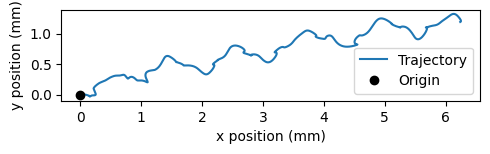

In [3]:
import matplotlib.pyplot as plt

with open(output_dir / "tripod_flat_train_set_1.00_1.00/sim_data.pkl", "rb") as f:
    sim_data_flat = pickle.load(f)

trajectory = np.array([obs["fly"][0, :2] for obs in sim_data_flat["obs_hist"]])

fig, ax = plt.subplots(figsize=(5, 2), tight_layout=True)
ax.plot(trajectory[:, 0], trajectory[:, 1], label="Trajectory")
ax.plot([0], [0], "ko", label="Origin")
ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("x position (mm)")
ax.set_ylabel("y position (mm)")
fig.savefig(output_dir / "head_stabilization_trajectory_sample.png")

We can also plot the time series of the variables that we are interested in, namely:

- **Joint angles** of all leg degrees of freedom (DoFs), 7 real values per leg per step
- **Leg contact** mask, 1 Boolean value per leg per step
- The appropriate neck **roll** needed to cancel out body rotation, 1 real value per step
- The appropriate neck **pitch** needed to cancel out body rotation, 1 real value per step

Note that we do not correct for rotation on the yaw axis. This is to avoid delineating unintended body oscillation the from intentional turning — a task outside the scope of this tutorial.

To get the leg contacts, we will use a contact force threshold of 0.5 mN for the front legs, 1 mN for the middle legs, and 3 mN for the hind legs — as was the case in the path integration tutorial.

To get the appropriate neck roll and pitch needed to cancel out body rotations, we will take the **quaternion** representing the thorax rotation, invert it, and convert it to **Euler angles**. Quaternions are a mathematical concept used to represent rotations in three dimensions. They avoid some of the pitfalls of other rotation representations, such as gimbal lock. However, quaternions are less intuitive to interpret and their elements do not directly correspond to the axes on the fly body. Therefore, we convert the inverted angles to Euler angles with more familiar axes of rotation (pitch, roll, yaw). More information about representation of 3D rotation can be found on [this Wikipedia article](https://en.wikipedia.org/wiki/Rotation_formalisms_in_three_dimensions).

For simplicity of visualization, we will only plot the legs on the left side:

In [4]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

dofs_per_leg = [
    "ThC pitch",
    "ThC roll",
    "ThC yaw",
    "CTr pitch",
    "CTr roll",
    "FTi pitch",
    "TiTa pitch",
]
contact_force_thr = np.array([0.5, 1.0, 3.0, 0.5, 1.0, 3.0])  # LF LM LH RF RM RH


def visualize_trial_data(obs_hist, info_hist, output_path):
    t_grid = np.arange(len(obs_hist)) * 1e-4

    # Extract joint angles
    joint_angles = np.array([obs["joints"][0, :] for obs in obs_hist])

    # Extract ground contact
    contact_forces = np.array([obs["contact_forces"] for obs in obs_hist])
    # get magnitude from xyz vector:
    contact_forces = np.linalg.norm(contact_forces, axis=2)
    # sum over 6 segments per leg (contact sensing enabled for tibia and 5 tarsal segments):
    contact_forces = contact_forces.reshape(-1, 6, 6).sum(axis=2)
    contact_mask = contact_forces >= contact_force_thr

    # Extract head rotation
    roll = np.array([info["roll"] for info in info_hist])
    pitch = np.array([info["pitch"] for info in info_hist])

    # Visualize
    fig, axs = plt.subplots(
        6, 1, figsize=(6, 9), tight_layout=True, height_ratios=[3, 3, 3, 2, 3, 1]
    )

    # Legs
    for i, leg in enumerate(["Left front leg", "Left middle leg", "Left hind leg"]):
        ax = axs[i]
        # Plot joint angles
        for j, dof in enumerate(dofs_per_leg):
            dof_idx = i * len(dofs_per_leg) + j
            ax.plot(t_grid, np.rad2deg(joint_angles[:, dof_idx]), label=dof, lw=1)
        ax.set_title(leg)
        ax.set_ylabel(r"Joint angle ($^\circ$)")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
        # Plot ground contact
        bool_ts = contact_mask[:, i]
        diff_ts = np.diff(bool_ts.astype(int), prepend=0)
        if bool_ts[0]:
            diff_ts[0] = 1
        if bool_ts[-1]:
            diff_ts[-1] = -1
        upedges = np.where(diff_ts == 1)[0]
        downedges = np.where(diff_ts == -1)[0]
        for up, down in zip(upedges, downedges):
            ax.axvspan(
                t_grid[up],
                t_grid[down],
                color="black",
                alpha=0.2,
                lw=0,
                label="Ground contact",
            )
        ax.set_xlabel("Time (s)")

    # Leg legends
    legend_elements = []
    for j, dof in enumerate(dofs_per_leg):
        legend_elements.append(Line2D([0], [0], color=f"C{j}", lw=1, label=dof))
    legend_elements.append(
        Patch(color="black", alpha=0.2, lw=0, label="Ground contact")
    )
    axs[3].legend(
        bbox_to_anchor=(0, 1.1, 1, 0.2),
        handles=legend_elements,
        loc="upper center",
        ncols=3,
        mode="expand",
        frameon=False,
    )
    axs[3].axis("off")

    # Head movement
    ax = axs[4]
    ax.plot(t_grid, np.rad2deg(roll), label="Head roll", lw=2, color="midnightblue")
    ax.plot(t_grid, np.rad2deg(pitch), label="Head pitch", lw=2, color="saddlebrown")
    ax.set_title("Head movement")
    ax.set_ylabel(r"Angle ($^\circ$)")
    ax.set_ylim(-20, 20)
    ax.set_xlabel("Time (s)")

    # Head legends
    legend_elements = [
        Line2D([0], [0], color=f"midnightblue", lw=2, label="Roll"),
        Line2D([0], [0], color=f"saddlebrown", lw=2, label="Pitch"),
    ]
    axs[5].legend(
        bbox_to_anchor=(0, 1.4, 1, 0.2),
        handles=legend_elements,
        loc="upper center",
        ncols=2,
        mode="expand",
        frameon=False,
    )
    axs[5].axis("off")

    fig.savefig(output_path)

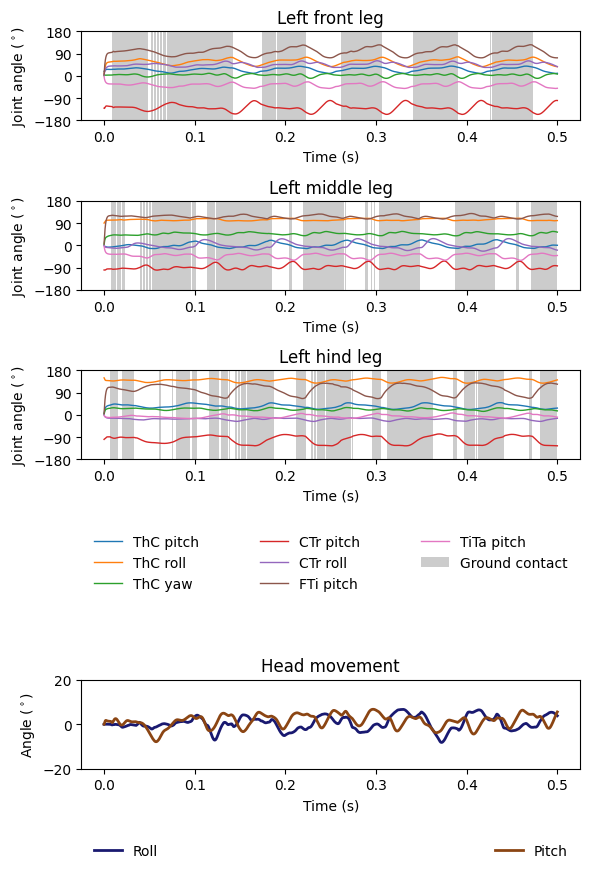

In [5]:
visualize_trial_data(
    sim_data_flat["obs_hist"],
    sim_data_flat["info_hist"],
    output_dir / "head_stabilization_flat_terrain_ts_sample.png",
)

We observe that, after about 0.1 seconds of transient response, we can indeed see the gait cycles from the input variables.

If we run another simulation over rugged terrain, the body oscillations appear more dramatic:

In [6]:
run_simulation(
    gait="tripod",
    terrain="blocks",
    spawn_xy=(0, 0),
    dn_drive=(1, 1),
    sim_duration=0.5,
    enable_rendering=True,
    live_display=False,
    output_dir=output_dir / "tripod_blocks_train_set_1.00_1.00",
    pbar=True,
)

100%|██████████| 5000/5000 [00:21<00:00, 235.63it/s]


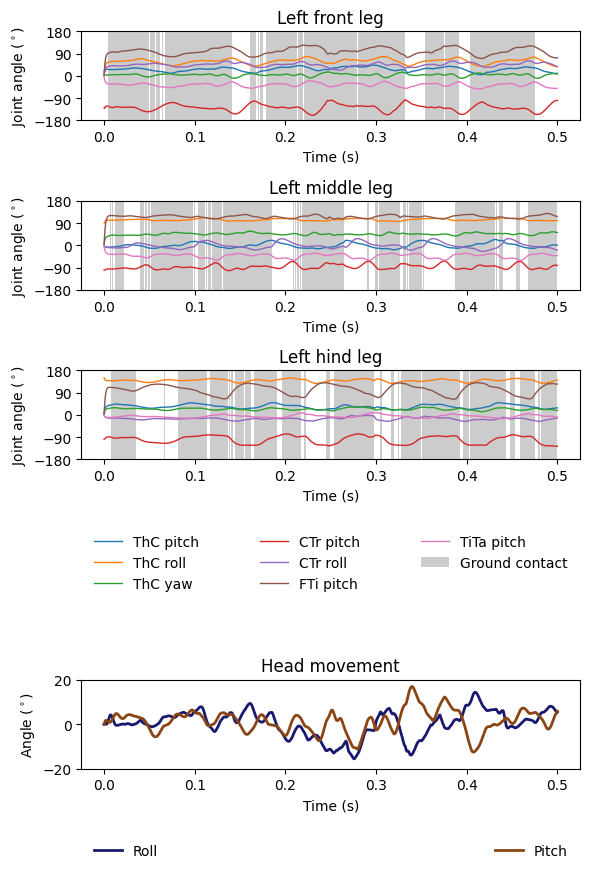

In [7]:
with open(output_dir / "tripod_blocks_train_set_1.00_1.00/sim_data.pkl", "rb") as f:
    sim_data_blocks = pickle.load(f)

visualize_trial_data(
    sim_data_blocks["obs_hist"],
    sim_data_blocks["info_hist"],
    output_dir / "head_stabilization_blocks_terrain_ts_sample.png",
)

## Training an internal model to control neck actuation

In the previous section, we have extracted the ascending sensory signals and the target motor outputs that are the model's inputs and outputs. Now, we will train a multilayer perceptron (MLP) that predicts the appropriate neck actuation signals using this ascending mechanosensory information. We will split this task into three technical steps:

1. Implementing a custom PyTorch dataset class to feed our data, through a dataloader, into the model
2. Defining an MLP with three hidden layers
3. Training the MLP using the data we have gathered and the data pipeline that we will have developed

### Implementing a custom PyTorch dataset

When training any machine learning or statistical model, it is often desired to normalize or standardize the input. We will start by implementing a `JointAngleScaler` class to do standardize joint angle data (subtract mean, divide by standard deviation). This class can be initialized in one of two ways:

1. A `.from_data` method that calculates the mean and standard deviation from a given dataset.
2. A `.from_params` method that uses given user-specified mean and and standard deviation.

This way, we can compute the mean and standard deviation from one trial and use the same parameters on all datasets.


In [8]:
class JointAngleScaler:
    """
    A class for standardizing joint angles (i.e., using mean and standard
    deviation.

    Attributes
    ----------
    mean : np.ndarray
        The mean values used for scaling.
    std : np.ndarray
        The standard deviation values used for scaling.
    """

    @classmethod
    def from_data(cls, joint_angles: np.ndarray):
        """
        Create a JointAngleScaler instance from joint angle data. The mean
        and standard deviation values are calculated from the data.

        Parameters
        ----------
        joint_angles : np.ndarray
            The joint angle data. The shape should be (n_samples, n_joints)
            where n_samples is, for example, the length of a time series of
            joint angles.

        Returns
        -------
        JointAngleScaler
            A JointAngleScaler instance.
        """
        scaler = cls()
        scaler.mean = np.mean(joint_angles, axis=0)
        scaler.std = np.std(joint_angles, axis=0)
        return scaler

    @classmethod
    def from_params(cls, mean: np.ndarray, std: np.ndarray):
        """
        Create a JointAngleScaler instance from predetermined mean and
        standard deviation values.

        Parameters
        ----------
        mean : np.ndarray
            The mean values. The shape should be (n_joints,).
        std : np.ndarray
            The standard deviation values. The shape should be (n_joints,).

        Returns
        -------
        JointAngleScaler
            A JointAngleScaler instance.
        """
        scaler = cls()
        scaler.mean = mean
        scaler.std = std
        return scaler

    def __call__(self, joint_angles: np.ndarray):
        """
        Scale the given joint angles.

        Parameters
        ----------
        joint_angles : np.ndarray
            The joint angles to be scaled. The shape should be (n_samples,
            n_joints) where n_samples is, for example, the length of a time
            series of joint angles.

        Returns
        -------
        np.ndarray
            The scaled joint angles.
        """
        return (joint_angles - self.mean) / self.std

Then, we will construct a PyTorch dataset class. This class can be seen as an "adapter": on one side, it interfaces the specifics of our data (data structure, format, etc.); on the other side, it outputs what PyTorch models expect, so that the neural network can work with it. See [this tutorial from Pytorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for more details on the Dataset interface.

In [9]:
from torch.utils.data import Dataset
from typing import Optional, Callable


class WalkingDataset(Dataset):
    """
    PyTorch Dataset class for walking data.

    Parameters
    ----------
    sim_data_file : Path
        The path to the simulation data file.
    contact_force_thr : tuple[float, float, float], optional
        The threshold values for contact forces, by default (0.5, 1, 3).
    joint_angle_scaler : Optional[Callable], optional
        A callable object used to scale joint angles, by default None.
    ignore_first_n : int, optional
        The number of initial data points to ignore, by default 200.
    joint_mask : Optional, optional
        A mask to apply on joint angles, by default None.

    Attributes
    ----------
    gait : str
        The type of gait.
    terrain : str
        The type of terrain.
    subset : str
        The subset of the data, i.e., "train" or "test".
    dn_drive : str
        The DN drive used to generate the data.
    contact_force_thr : np.ndarray
        The threshold values for contact forces.
    joint_angle_scaler : Callable
        The callable object used to scale joint angles.
    ignore_first_n : int
        The number of initial data points to ignore.
    joint_mask : Optional
        The mask applied on joint angles. This is used to zero out certain
        DoFs to evaluate which DoFs are likely more important for head
        stabilization.
    contains_fly_flip : bool
        Indicates if the simulation data contains fly flip errors.
    contains_physics_error : bool
        Indicates if the simulation data contains physics errors.
    roll_pitch_ts : np.ndarray
        The optimal roll and pitch correction angles. The shape is
        (n_samples, 2).
    joint_angles : np.ndarray
        The scaled joint angle time series. The shape is (n_samples,
        n_joints).
    contact_mask : np.ndarray
        The contact force mask (i.e., 1 if leg touching the floor, 0
        otherwise). The shape is (n_samples, 6).
    """

    def __init__(
        self,
        sim_data_file: Path,
        contact_force_thr: tuple[float, float, float] = (0.5, 1, 3),
        joint_angle_scaler: Optional[Callable] = None,
        ignore_first_n: int = 200,
        joint_mask=None,
    ) -> None:
        super().__init__()
        trial_name = sim_data_file.parent.name
        gait, terrain, subset, _, dn_left, dn_right = trial_name.split("_")
        self.gait = gait
        self.terrain = terrain
        self.subset = subset
        self.dn_drive = f"{dn_left}_{dn_right}"
        self.contact_force_thr = np.array([*contact_force_thr, *contact_force_thr])
        self.joint_angle_scaler = joint_angle_scaler
        self.ignore_first_n = ignore_first_n
        self.joint_mask = joint_mask

        with open(sim_data_file, "rb") as f:
            sim_data = pickle.load(f)

        self.contains_fly_flip = sim_data["errors"]["fly_flipped"]
        self.contains_physics_error = sim_data["errors"]["physics_error"]

        # Extract the roll and pitch angles
        roll = np.array([info["roll"] for info in sim_data["info_hist"]])
        pitch = np.array([info["pitch"] for info in sim_data["info_hist"]])
        self.roll_pitch_ts = np.stack([roll, pitch], axis=1)
        self.roll_pitch_ts = self.roll_pitch_ts[self.ignore_first_n :, :]

        # Extract joint angles and scale them
        joint_angles_raw = np.array(
            [obs["joints"][0, :] for obs in sim_data["obs_hist"]]
        )
        if self.joint_angle_scaler is None:
            self.joint_angle_scaler = JointAngleScaler.from_data(joint_angles_raw)
        self.joint_angles = self.joint_angle_scaler(joint_angles_raw)
        self.joint_angles = self.joint_angles[self.ignore_first_n :, :]

        # Extract contact forces
        contact_forces = np.array(
            [obs["contact_forces"] for obs in sim_data["obs_hist"]]
        )
        contact_forces = np.linalg.norm(contact_forces, axis=2)  # magnitude
        contact_forces = contact_forces.reshape(-1, 6, 6).sum(axis=2)  # sum per leg
        self.contact_mask = (contact_forces >= self.contact_force_thr).astype(np.int16)
        self.contact_mask = self.contact_mask[self.ignore_first_n :, :]

    def __len__(self):
        return self.roll_pitch_ts.shape[0]

    def __getitem__(self, idx):
        joint_angles = self.joint_angles[idx].astype(np.float32, copy=True)
        if self.joint_mask is not None:
            joint_angles[~self.joint_mask] = 0
        return {
            "roll_pitch": self.roll_pitch_ts[idx].astype(np.float32),
            "joint_angles": joint_angles,
            "contact_mask": self.contact_mask[idx].astype(np.float32),
        }

We can test the joint angle scaler and dataset classes using our trial simulation:

In [10]:
joint_angles = np.array([obs["joints"][0, :] for obs in sim_data_flat["obs_hist"]])
joint_scaler = JointAngleScaler.from_data(joint_angles)
dataset = WalkingDataset(
    sim_data_file=output_dir / "tripod_flat_train_set_1.00_1.00/sim_data.pkl",
    joint_angle_scaler=joint_scaler,
    ignore_first_n=200,
)
with open(output_dir / "head_stabilization_joint_angle_scaler_params.pkl", "wb") as f:
    pickle.dump({"mean": joint_scaler.mean, "std": joint_scaler.std}, f)

Let's plot the joint angles for the left front leg again, but using the dataset as an iterator instead of the output returned by `run_simulation`:

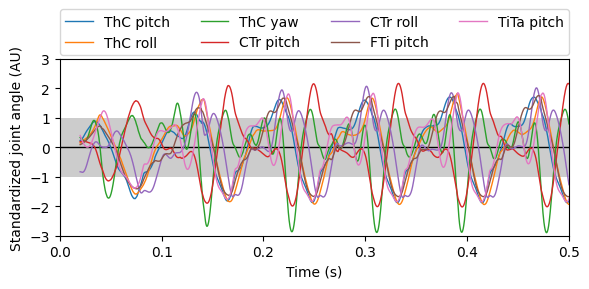

In [11]:
t_grid = np.arange(200, 200 + len(dataset)) * 1e-4
joint_angles = np.array([entry["joint_angles"] for entry in dataset])

fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.axhline(0, color="black", lw=1)
ax.axhspan(-1, 1, color="black", alpha=0.2, lw=0)
for i, dof in enumerate(dofs_per_leg):
    ax.plot(t_grid, joint_angles[:, i], label=dof, lw=1)
ax.legend(
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="lower left",
    mode="expand",
    borderaxespad=0,
    ncol=4,
)
ax.set_xlim(0, 0.5)
ax.set_ylim(-3, 3)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Standardized joint angle (AU)")
fig.savefig(output_dir / "head_stabilization_joint_angles_scaled.png")

We observe that the joint angles now share a mean of 0 (black line) and standard deviation of 1 (gray shade).

We can further use the PyTorch dataloader to fetch data in batches. This is useful for training the MLP in the next step. As an example, we can create a dataset that gives us a shuffled batch of 32 samples at a time:

In [12]:
from torch.utils.data import DataLoader

example_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in example_loader:
    for key, value in batch.items():
        print(f"{key}\tshape: {value.shape}")
    break

roll_pitch	shape: torch.Size([32, 2])
joint_angles	shape: torch.Size([32, 42])
contact_mask	shape: torch.Size([32, 6])


### Defining an MLP

Having implemented the data pipeline, we will now define the model itself. We will use [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), a framework built on top of PyTorch that simplifies checkpointing (saving snapshots of model parameters during training), logging, etc.

In brief, our `ThreeLayerMLP` class, implemented below, consists of the following:

- An `__init__` method that creates three hidden layers and a `R2Score` object that calculates the $R^2$ score.
- A `forward` method that implements the forward pass of the neural network — a process where we traverse layers in the network to calculate values of the output layer based on the input. In our case, we simply apply the three hidden layers sequentially, with a Rectified Linear Unit (ReLU) activation function at the end of the first two layers. Based on this method, PyTorch will automatically implement the backward pass — a process in gradient-based optimization algorithms where, after the forward pass, the gradients for parameters in all layers are traced, starting from the gradient of the loss on the outputs (i.e., last layer).
- A `configure_optimizer` method that sets up the optimizer — in our case an [Adam optimizer](https://arxiv.org/abs/1412.6980) with a learning rate of 0.001.
- A `training_step` method that defines the operation to be conducted for each training step (i.e. every time the model receives a new batch of training data). Here, we concatenate the joint angles and leg contact masks into a single input block, run the forward pass (we can simply call the module itself on in the input for this), and calculate the MSE loss. Then, we log the loss as *training loss* and return it. PyTorch Lightning will do the backpropagation for us.
- A `validation_step` method that defines what the model should do every time a batch of validation data is received. Similar to `training_step`, we run the forward pass, but this time we calculate the $R^2$ scores in addition to the MSE loss. Lastly, we log the $R^2$ and MSE metrics accordingly.

For more information on implementing a PyTorch Lightning module, see [this tutorial](https://lightning.ai/courses/deep-learning-fundamentals/overview-organizing-your-code-with-pytorch-lightning/5-2-training-a-multilayer-perceptron-using-the-lightning-trainer/).

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as pl
from torchmetrics.regression import R2Score


pl.seed_everything(0, workers=True)


class ThreeLayerMLP(pl.LightningModule):
    """
    A PyTorch Lightning module for a three-layer MLP that predicts the
    head roll and pitch correction angles based on proprioception and
    tactile information.
    """

    def __init__(self):
        super().__init__()
        input_size = 42 + 6
        hidden_size = 32
        output_size = 2
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.r2_score = R2Score()

    def forward(self, x):
        """
        Forward pass through the model.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor. The shape should be (n_samples, 42 + 6)
            where 42 is the number of joint angles and 6 is the number of
            contact masks.
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

    def configure_optimizers(self):
        """Use the Adam optimizer."""
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        """Training step of the PyTorch Lightning module."""
        x = torch.concat([batch["joint_angles"], batch["contact_mask"]], dim=1)
        y = batch["roll_pitch"]
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step of the PyTorch Lightning module."""
        x = torch.concat([batch["joint_angles"], batch["contact_mask"]], dim=1)
        y = batch["roll_pitch"]
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log("val_loss", loss)
        if y.shape[0] > 1:
            r2_roll = self.r2_score(y_hat[:, 0], y[:, 0])
            r2_pitch = self.r2_score(y_hat[:, 1], y[:, 1])
        else:
            r2_roll, r2_pitch = np.nan, np.nan
        self.log("val_r2_roll", r2_roll)
        self.log("val_r2_pitch", r2_pitch)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


### Training the model

Having implemented the data pipeline and defined the model, we will now train the model. We have pre-generated 126 simulation trials, including 11 training trials and 10 testing trials with different descending drives, for each of the three gait patterns (tripod gait, tetrapod gait, and wave gait), and for flat and blocks terrain types. Of these, we exclude one simulation (wave gait, blocks terrain, test set, DN drives [0.58, 1.14]) because the fly flipped while walking. You can download this dataset by running the code block below.

In [14]:
# TODO. We are working with our IT team to set up a gateway to share these data publicly
# in a secure manner. We aim to update this by the end of June, 2024. Please reach out
# to us by email in the meantime.

In [15]:
simulation_data_dir = (
    Path.home() / "Data/flygym_demo_data/head_stabilization/random_exploration/"
)

if not simulation_data_dir.is_dir():
    raise FileNotFoundError(
        "Pregenerated simulation data not found. Please download it from TODO."
    )
else:
    print(f"[OK] Pregenerated simulation data found. Ready to proceed.")

[OK] Pregenerated simulation data found. Ready to proceed.


Let's generate a `WalkingDataset` object (implemented above) for each training trial and concatenate them.

In [16]:
from torch.utils.data import ConcatDataset

dataset_list = []
for gait in ["tripod", "tetrapod", "wave"]:
    for terrain in ["flat", "blocks"]:
        paths = simulation_data_dir.glob(f"{gait}_{terrain}_train_set_*")
        print(f"Loading {gait} gait, {terrain} terrain...")
        dn_drives = ["_".join(p.name.split("_")[-2:]) for p in paths]
        for dn_drive in dn_drives:
            sim = f"{gait}_{terrain}_train_set_{dn_drive}"
            path = simulation_data_dir / f"{sim}/sim_data.pkl"
            ds = WalkingDataset(path, joint_angle_scaler=joint_scaler)
            ds.joint_mask = np.ones(42, dtype=bool)  # use all joints
            dataset_list.append(ds)
concat_train_set = ConcatDataset(dataset_list)

print(f"Training dataset size: {len(dataset)}")

Loading tripod gait, flat terrain...
Loading tripod gait, blocks terrain...
Loading tetrapod gait, flat terrain...
Loading tetrapod gait, blocks terrain...
Loading wave gait, flat terrain...
Loading wave gait, blocks terrain...
Training dataset size: 4800


The size is as expected: (3 gaits × 2 terrain types × 11 DN combinations) × (0.5 seconds of simulation / 0.0001 seconds per step – 200 transient steps excluded) = 976,800 samples in total.

We will further divide the training set into the training set a validation set at a ratio of 4:1:

- The training set is used to optimize the parameters of the model.
- The validation set is used to check if the model has been overfitted.
- The testing set is held out throughout the entire training procedure. It consists of trials simulated using a different set of descending drives and is only used to report the final out-of-sample performance of the model.

In [17]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(concat_train_set, [0.8, 0.2])

As demonstrated above, we will create dataloaders for the training and validation sets to load the data in batches:

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=256, num_workers=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1028, num_workers=4, shuffle=False)

Finally, we will set up a logger to keep track of the training progress, a checkpoint callback that saves snapshots of model parameters while training, and a trainer object to orchestrate the training procedure:

In [19]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from shutil import rmtree

log_dir = Path(output_dir / "logs")
if log_dir.is_dir():
    rmtree(log_dir)
logger = CSVLogger(log_dir, name="demo_trial")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=output_dir / "models/checkpoints",
    filename="%s-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,  # Save only the best checkpoint
    mode="min",  # `min` for minimizing the validation loss
)
model = ThreeLayerMLP()
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=10,
    check_val_every_n_epoch=1,
    deterministic=True,
)

/home/sibwang/anaconda3/envs/flygym312/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/sibwang/anaconda3/envs/flygym312/lib/python3.12/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU avai

We are now ready to train the model. We will train the model for 10 epochs. On a machine with a NVIDIA GeForce RTX 3080 Ti GPU (2021), this takes about 2 minutes.

In [20]:
trainer.fit(model, train_loader, val_loader)

/home/sibwang/anaconda3/envs/flygym312/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/sibwang/Projects/flygym/notebooks/outputs/models/checkpoints exists and is not empty.
INFO: 
  | Name     | Type    | Params
-------------------------------------
0 | layer1   | Linear  | 1.6 K 
1 | layer2   | Linear  | 1.1 K 
2 | layer3   | Linear  | 66    
3 | r2_score | R2Score | 0     
-------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type    | Params
-------------------------------------
0 | layer1   | Linear  | 1.6 K 
1 | layer2   | Linear  | 1.1 K 
2 | layer3   | Linear  | 66    
3 | r2_score | R2Score | 0     
-------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Let's inspect the model's performance on the training and validation sets changed over time. On the validation set, we will plot the loss and $R^2$ scores at the end of each epoch.

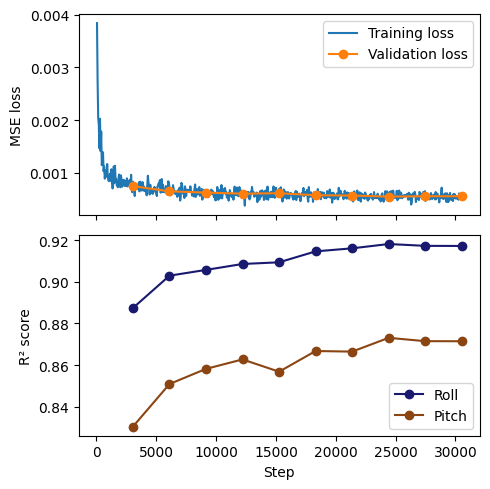

In [21]:
import pandas as pd

logs = pd.read_csv(log_dir / "demo_trial/version_0/metrics.csv")

fig, axs = plt.subplots(2, 1, figsize=(5, 5), tight_layout=True, sharex=True)

ax = axs[0]
mask = np.isfinite(logs["train_loss"])
ax.plot(logs["step"][mask], logs["train_loss"][mask], label="Training loss")
mask = np.isfinite(logs["val_loss"])
ax.plot(logs["step"][mask], logs["val_loss"][mask], label="Validation loss", marker="o")
ax.legend()
ax.set_ylabel("MSE loss")

ax = axs[1]
ax.plot(
    logs["step"][mask],
    logs["val_r2_roll"][mask],
    color="midnightblue",
    label="Roll",
    marker="o",
)
ax.plot(
    logs["step"][mask],
    logs["val_r2_pitch"][mask],
    color="saddlebrown",
    label="Pitch",
    marker="o",
)
ax.legend(loc="lower right")
ax.set_xlabel("Step")
ax.set_ylabel("R² score")

fig.savefig(output_dir / "head_stabilization_training_metrics.png")

Satisfied with the performance, we now proceed to evaluate the model on the testing set and deploy it in closed loop.

## Deploying the model

While the PyTorch module `ThreeLayerMLP` can give us predictions, it is not very lean: a number of training-related elements are exposed to the caller. For example, the `forward` method expects a _batch_ of data concatenated in a specific way, and PyTorch will try to load it on an accelerated hardware automatically if one is found. This is not ideal for _real time_ deployment — we will only get one input snapshot at a time and the data is small enough and the steps frequent enough that it not worth loading/unloading data to the GPU every step. Therefore, as a next step, we will write a wrapper that provides a minimal interface that simplifies making single-step predictions natively on the CPU:

In [22]:
class HeadStabilizationInferenceWrapper:
    """
    Wrapper for the head stabilization model to make predictions on
    observations. Whereas data are collected in large tensors during
    training, this class provides a "flat" interface for making predictions
    one observation (i.e., time step) at a time. This is useful for
    deploying the model in closed loop.
    """

    def __init__(
        self,
        model_path: Path,
        scaler_param_path: Path,
        contact_force_thr: tuple[float, float, float] = (0.5, 1, 3),
    ):
        """
        Parameters
        ----------
        model_path : Path
            The path to the trained model.
        scaler_param_path : Path
            The path to the pickle file containing scaler parameters.
        contact_force_thr : tuple[float, float, float], optional
            The threshold values for contact forces that are used to
            determine the floor contact flags, by default (0.5, 1, 3).
        """
        # Load scaler params
        with open(scaler_param_path, "rb") as f:
            scaler_params = pickle.load(f)
        self.scaler_mean = scaler_params["mean"]
        self.scaler_std = scaler_params["std"]

        # Load model
        # it's not worth moving data to the GPU, just run it on the CPU
        self.model = ThreeLayerMLP.load_from_checkpoint(
            model_path, map_location=torch.device("cpu")
        )
        self.contact_force_thr = np.array([*contact_force_thr, *contact_force_thr])

    def __call__(
        self, joint_angles: np.ndarray, contact_forces: np.ndarray
    ) -> np.ndarray:
        """
        Make a prediction given joint angles and contact forces. This is
        a light wrapper around the model's forward method and works without
        batching.

        Parameters
        ----------
        joint_angles : np.ndarray
            The joint angles. The shape should be (n_joints,).
        contact_forces : np.ndarray
            The contact forces. The shape should be (n_legs * n_segments).

        Returns
        -------
        np.ndarray
            The predicted roll and pitch angles. The shape is (2,).
        """
        joint_angles = (joint_angles - self.scaler_mean) / self.scaler_std
        contact_forces = np.linalg.norm(contact_forces, axis=1)
        contact_forces = contact_forces.reshape(6, 6).sum(axis=1)
        contact_mask = contact_forces >= self.contact_force_thr
        x = np.concatenate([joint_angles, contact_mask], dtype=np.float32)
        input_tensor = torch.tensor(x[None, :], device=torch.device("cpu"))
        output_tensor = self.model(input_tensor)
        return output_tensor.detach().numpy().squeeze()

Let's load the model from the saved checkpoint:

In [23]:
model_wrapper = HeadStabilizationInferenceWrapper(
    model_path=checkpoint_callback.best_model_path,
    scaler_param_path=output_dir / "head_stabilization_joint_angle_scaler_params.pkl",
)

To deploy the head stabilization model in closed loop, we will write a `run_simulation_closed_loop` function:

In [24]:
from flygym.arena import BaseArena
from sklearn.metrics import r2_score

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]


def run_simulation_closed_loop(
    arena: BaseArena,
    run_time: float = 0.5,
    head_stabilization_model: Optional[HeadStabilizationInferenceWrapper] = None,
):
    fly = Fly(
        contact_sensor_placements=contact_sensor_placements,
        vision_refresh_rate=500,
        neck_kp=500,
        head_stabilization_model=head_stabilization_model,
    )
    sim = HybridTurningController(fly=fly, arena=arena)
    sim.reset(seed=0)

    # These are updated at every time step and are used for generating
    # statistics and plots (except vision_all, which is updated every
    # time step where the visual input is updated. Visual updates are less
    # frequent than physics steps).
    head_rotation_hist = []
    thorax_rotation_hist = []
    neck_actuation_pred_hist = []  # model-predicted neck actuation
    neck_actuation_true_hist = []  # ideal neck actuation

    thorax_body = fly.model.find("body", "Thorax")
    head_body = fly.model.find("body", "Head")

    # Main simulation loop
    for i in trange(int(run_time / sim.timestep)):
        try:
            obs, _, _, _, info = sim.step(action=np.array([1, 1]))
        except PhysicsError:
            print("Physics error, ending simulation early")
            break

        # Record neck actuation for stats at the end of the simulation
        if head_stabilization_model is not None:
            neck_actuation_pred_hist.append(info["neck_actuation"])
        quat = sim.physics.bind(fly.thorax).xquat
        quat_inv = transformations.quat_inv(quat)
        roll, pitch, _ = transformations.quat_to_euler(quat_inv, ordering="XYZ")
        neck_actuation_true_hist.append(np.array([roll, pitch]))

        # Record head and thorax orientation
        thorax_rotation_quat = sim.physics.bind(thorax_body).xquat
        thorax_roll, thorax_pitch, _ = transformations.quat_to_euler(
            thorax_rotation_quat, ordering="XYZ"
        )
        thorax_rotation_hist.append([thorax_roll, thorax_pitch])
        head_rotation_quat = sim.physics.bind(head_body).xquat
        head_roll, head_pitch, _ = transformations.quat_to_euler(
            head_rotation_quat, ordering="XYZ"
        )
        head_rotation_hist.append([head_roll, head_pitch])

    # Generate performance stats on head stabilization
    if head_stabilization_model is not None:
        neck_actuation_true_hist = np.array(neck_actuation_true_hist)
        neck_actuation_pred_hist = np.array(neck_actuation_pred_hist)
        r2_scores = {
            # exclude the first 200 frames (transient response)
            "roll": r2_score(
                neck_actuation_true_hist[200:, 0], neck_actuation_pred_hist[200:, 0]
            ),
            "pitch": r2_score(
                neck_actuation_true_hist[200:, 1], neck_actuation_pred_hist[200:, 1]
            ),
        }
    else:
        r2_scores = None
        neck_actuation_true_hist = np.array(neck_actuation_true_hist)
        neck_actuation_pred_hist = np.zeros_like(neck_actuation_true_hist)

    return {
        "sim": sim,
        "neck_true": neck_actuation_true_hist,
        "neck_pred": neck_actuation_pred_hist,
        "r2_scores": r2_scores,
        "head_rotation_hist": np.array(head_rotation_hist),
        "thorax_rotation_hist": np.array(thorax_rotation_hist),
    }

To apply the model-predicted neck actuation signals, we have simply passed the model as the `head_stabilization_model` parameter to the `Fly` object. Under the hood, the `Fly` object initializes actuators for the neck roll and pitch DoFs upon `__init__`. Then, at each simulation step, the `Fly` class runs the `head_stabilization_model` and actuates the appropriate DoFs in addition to the user-specified actions. In code, this is implemented as follows:
```python
class Fly:
    def __init__(... head_stabilization_model ...):
        ...
        
        # Check neck actuation if head stabilization is enabled
        if head_stabilization_model is not None:
            if "joint_Head_yaw" in actuated_joints or "joint_Head" in actuated_joints:
                raise ValueError(
                    "The head joints are actuated by a preset algorithm. "
                    "However, the head joints are already included in the "
                    "provided Fly instance. Please remove the head joints from "
                    "the list of actuated joints."
                )
            self._last_neck_actuation = None  # tracked only for head stabilization
        
        ...
        
        self.actuated_joints = actuated_joints
        self.head_stabilization_model = head_stabilization_model
        
        ...

        if self.head_stabilization_model is not None:
            self.neck_actuators = [
                self.model.actuator.add(
                    self.control,
                    name=f"actuator_position_{joint}",
                    joint=joint,
                    kp=neck_kp,
                    ctrlrange="-1000000 1000000",
                    forcelimited=False,
                )
                for joint in ["joint_Head_yaw", "joint_Head"]
            ]
    
    ...
    
    def pre_step(self, action, sim):
        joint_action = action["joints"]

        # estimate necessary neck actuation signals for head stabilization
        if self.head_stabilization_model is not None:
            if self._last_observation is not None:
                leg_joint_angles = self._last_observation["joints"][0, :]
                leg_contact_forces = self._last_observation["contact_forces"]
                neck_actuation = self.head_stabilization_model(
                    leg_joint_angles, leg_contact_forces
                )
            else:
                neck_actuation = np.zeros(2)
            joint_action = np.concatenate((joint_action, neck_actuation))
            self._last_neck_actuation = neck_actuation
            physics.bind(self.actuators + self.neck_actuators).ctrl = joint_action
    
    def post_step(self, sim):
        obs, reward, terminated, truncated, info = ...

        ...

        if self.head_stabilization_model is not None:
            # this is tracked to decide neck actuation for the next step
            info["neck_actuation"] = self._last_neck_actuation
        
        return obs, reward, terminated, truncated, info

class Simulation:
    ...

    def step(self, action):
        ...
        self.fly.pre_step(action, self)
        obs, reward, terminated, truncated, info = self.fly.post_step()
        return obs, reward, terminated, truncated, info

```

Now, we can run the simulation over flat and blocks terrain again:

In [25]:
arena = FlatTerrain()
sim_data_flat = run_simulation_closed_loop(
    arena=arena, run_time=1, head_stabilization_model=model_wrapper
)

arena = BlocksTerrain(height_range=(0.2, 0.2))
sim_data_blocks = run_simulation_closed_loop(
    arena=arena, run_time=1, head_stabilization_model=model_wrapper
)

100%|██████████| 10000/10000 [00:33<00:00, 299.90it/s]


In [26]:
print(f"R² scores over flat terrain: {sim_data_flat['r2_scores']}")
print(f"R² scores over blocks terrain: {sim_data_blocks['r2_scores']}")

R² scores over flat terrain: {'roll': 0.8720892058987814, 'pitch': 0.9293070918490837}
R² scores over blocks terrain: {'roll': 0.5792754921973917, 'pitch': 0.7106359552091986}


Based on these results, we can plot the time series of the model-predicted neck actuation signals and the ideal neck actuation signals:

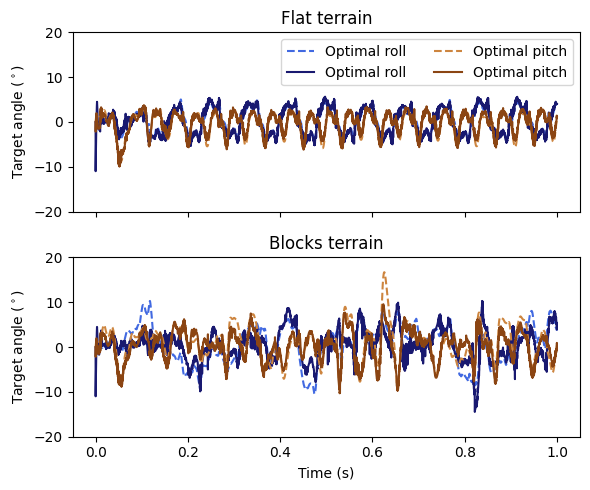

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(6, 5), tight_layout=True, sharex=True)
color_config = {
    "roll": ("royalblue", "midnightblue"),
    "pitch": ("peru", "saddlebrown"),
}

for ax, terrain, data in zip(axs, ["Flat", "Blocks"], [sim_data_flat, sim_data_blocks]):
    t_grid = np.arange(len(data["neck_true"])) * 1e-4
    for i, dof in enumerate(["roll", "pitch"]):
        ax.plot(
            t_grid,
            np.rad2deg(data["neck_true"][:, i]),
            label=f"Optimal {dof}",
            linestyle="--",
            color=color_config[dof][0],
        )
        ax.plot(
            t_grid,
            np.rad2deg(data["neck_pred"][:, i]),
            label=f"Optimal {dof}",
            color=color_config[dof][1],
        )
    ax.set_title(f"{terrain} terrain")
    ax.set_ylabel(r"Target angle ($^\circ$)")
    ax.set_ylim(-20, 20)
    if terrain == "Flat":
        ax.legend(ncols=2)
    if terrain == "Blocks":
        ax.set_xlabel("Time (s)")
fig.savefig(output_dir / "head_stabilization_neck_actuation_sample.png")

Similarly, we can plot the roll and pitch of the head compared to the thorax over time:

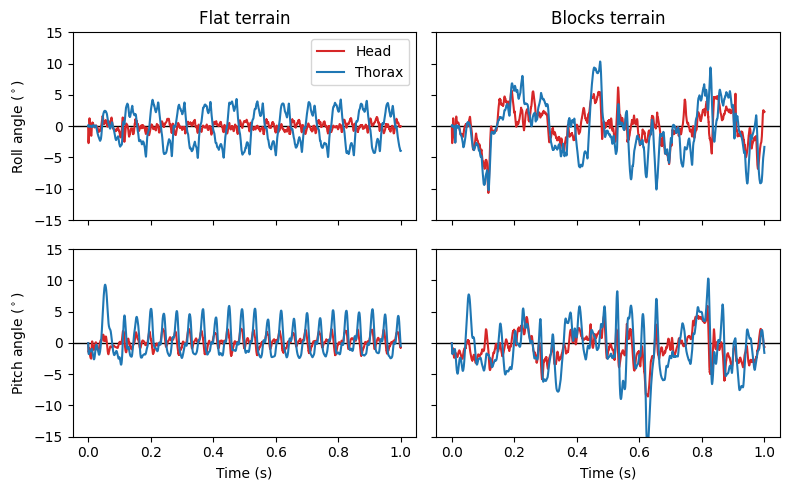

In [28]:
fig, axs = plt.subplots(
    2, 2, figsize=(8, 5), tight_layout=True, sharex=True, sharey=True
)

for i, (terrain, data) in enumerate(
    zip(["Flat", "Blocks"], [sim_data_flat, sim_data_blocks])
):
    for j, dof in enumerate(["roll", "pitch"]):
        ax = axs[j, i]
        ax.axhline(0, color="black", lw=1)
        ax.plot(
            t_grid,
            np.rad2deg(data["head_rotation_hist"][:, j]),
            label="Head",
            color="tab:red",
        )
        ax.plot(
            t_grid,
            np.rad2deg(data["thorax_rotation_hist"][:, j]),
            label="Thorax",
            color="tab:blue",
        )
        ax.set_ylim(-15, 15)
        if i == 0 and j == 0:
            ax.legend()
        if i == 0:
            ax.set_ylabel(rf"{dof.capitalize()} angle ($^\circ$)")
        if j == 0:
            ax.set_title(f"{terrain} terrain")
        if j == 1:
            ax.set_xlabel("Time (s)")
fig.savefig(output_dir / "head_stabilization_head_vs_thorax.png")

As expected, the rotation of the head has a lower magnitude than that of the body, even over complex terrain.